## Perceptron and Multi-Layer Perceptron from scratch

In this short notebook, I implement the perceptron algorithm and test with a classification task on the Iris dataset ([link](https://archive.ics.uci.edu/dataset/53/iris)), followed by a One vs All Multi-Layer Perceptron implementation.

In [1]:
import urllib.request
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Download the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
filename = 'iris.csv'
urllib.request.urlretrieve(url, filename)

# Load the dataset into a Pandas dataframe
column_names = [
    'sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'
]
data = pd.read_csv(filename, names=column_names)

EPOCHS = 10

data.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [2]:
# Label encode the "class"
irises = {"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}
data['class'] = data['class'].map(irises)
data.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
# Shuffle the dataset to ensure more even distribution
data = data.sample(frac=1, random_state=1234).reset_index(drop=True)
data.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,6.1,3.0,4.6,1.4,1
1,6.1,2.9,4.7,1.4,1
2,6.3,2.9,5.6,1.8,2
3,4.6,3.4,1.4,0.3,0
4,5.2,2.7,3.9,1.4,1


In [4]:
# Split the dataset
TRAIN = math.floor(0.8 * data.shape[0])
train = data[:TRAIN]
test = data[TRAIN:]

# Sanity check
assert train.shape[0] == TRAIN
assert test.shape[0] == (data.shape[0] - TRAIN)

In [5]:
class Perceptron:
    def __init__(self, numInputs):
        self.numInputs = numInputs
        self.w = np.zeros(numInputs)
        self.b = 0

    def predict(self, x):
        a = np.dot(x, self.w) + self.b
        return 1 if a > 0 else -1

    def train(self, X, y, epochs=EPOCHS):
        n = len(X)
        for i in range(n):
            if self.predict(X[i]) != y[i]:
                self.w += y[i] * X[i]
                self.b += y[i]
            # xi = X.iloc[i].to_numpy() if hasattr(X, 'iloc') else X[i]  # Convert pandas Series to numpy array
            # yi = y.iloc[i] if hasattr(y, 'iloc') else y[i]
            # if self.predict(xi) != yi:
            #     self.w += yi * xi
            #     self.b += yi

In [6]:
# Implementing One vs All
class MultiClassPerceptron:
    def __init__(self, numInputs, numClasses):
        self.numInputs = numInputs
        self.numClasses = numClasses
        self.perceptrons = [Perceptron(numInputs) for _ in range(numClasses)]

    def train(self, X, Y, epochs=10):
        accuracy_per_epoch = []

        for epoch in range(epochs):
            print("Epoch ", epoch)
            correct_predictions = 0
            for i, perceptron in enumerate(self.perceptrons):
                # For One vs All
                y_i = np.where(Y == i, 1, -1)

                # Ensuring compatibility with pandas DataFrame
                if isinstance(X, pd.DataFrame):
                    X_numpy = X.to_numpy()
                else:
                    X_numpy = X

                perceptron.train(X_numpy, y_i)

            # Calculate accuracy after each epoch
            for x, y in zip(X.itertuples(index=False), Y):
                x_numpy = np.array(x) if isinstance(X, pd.DataFrame) else x
                if self.predict(x_numpy) == y:
                    correct_predictions += 1
            accuracy = correct_predictions / len(Y)
            accuracy_per_epoch.append(accuracy)

        return accuracy_per_epoch

    def predict(self, x):
        # Ensure x is a 1D numpy array representing a single instance
        x_numpy = np.array(x).flatten()
        scores = np.array([perceptron.predict(x_numpy) for perceptron in self.perceptrons])
        return np.argmax(scores)

    def predict_all(self, X):
        # X is expected to be a 2D numpy array or a Pandas DataFrame
        # with each row being an instance to predict
        if isinstance(X, pd.DataFrame):
            X_numpy = X.to_numpy()
        else:
            X_numpy = X
        return np.array([self.predict(x) for x in X_numpy])

y_train = train["class"]
train.drop("class", axis=1, inplace=True)
X_train = train

print(X_train.shape, len(y_train))

mcp = MultiClassPerceptron(numInputs=4, numClasses=3)
accuracies = mcp.train(X_train, y_train, epochs=10)
print("Done.")

(120, 4) 120
Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Done.


<ipython-input-6-d739f383e098>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop("class", axis=1, inplace=True)


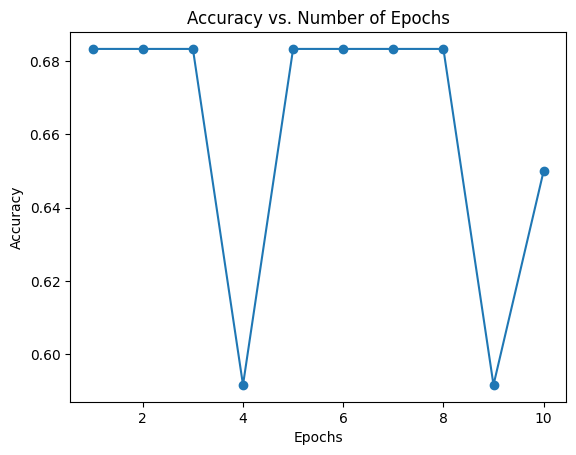

In [7]:
def plot_accuracy(accuracies, epochs):
    plt.plot(range(1, epochs + 1), accuracies, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs')
    plt.show()

plot_accuracy(accuracies, epochs=EPOCHS)

In [8]:
y_test = test["class"]
test.drop("class", axis=1, inplace=True)
X_test = test

print(X_test.shape, len(y_test))
print(test.head())

(30, 4) 30
     sepal_length  sepal_width  petal_length  petal_width
120           7.3          2.9           6.3          1.8
121           6.4          3.2           5.3          2.3
122           7.2          3.0           5.8          1.6
123           6.7          3.1           4.4          1.4
124           4.8          3.0           1.4          0.1


<ipython-input-8-797e702e574c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop("class", axis=1, inplace=True)


In [9]:
preds = mcp.predict_all(X_test)
test_accuracy = sum(preds == y_test) / len(preds)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.6666666666666666
